In [1]:
!pip install unidecode

     |████████████████████████████████| 235 kB 7.4 MB/s 


In [2]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 26.9 MB/s 


In [3]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import unidecode
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint

In [34]:
from keras.layers import Flatten

In [4]:
def load_dataset(filename):
    df = pd.read_csv(filename)
    print(df.head())
    intent = df["tags"]
    unique_intent = list(set(intent))
    sentences = list(df["patterns"])
  
    return (intent, unique_intent, sentences)

In [5]:
intent, unique_intent, sentences = load_dataset("intent - intent.csv")

            patterns                                           response  \
0                 Hi  ['Hello Human', 'Good To See You Again', 'Hey,...   
1        How are you  ['Hello Human', 'Good To See You Again', 'Hey,...   
2        How you are  ['Hello Human', 'Good To See You Again', 'Hey,...   
3  anyone Present Is  ['Hello Human', 'Good To See You Again', 'Hey,...   
4  anyone Is Present  ['Hello Human', 'Good To See You Again', 'Hey,...   

        tags  
0  greetings  
1  greetings  
2  greetings  
3  greetings  
4  greetings  


In [6]:
print(*sentences[:40], sep = "\n")

Hi
How are you
How you are
anyone Present Is
anyone Is Present
Good Day
up Whats
How Do You do
do Do You How
Do do You How
How Do do You
Hey
Hello
Greetings
Goodbye
Again See you
See you Again
Ciao
Hasta Vista La
Hasta La Vista
Au Revior
am I Leaving
Leaving I am
Help Thanks The For
Help Thanks For The
Thanks For Help The
Thanks Help The For
Have A Good Day
Good Day A Have
Have Good A Day
Good A Have Day
Care Take
Take Care
Thanks
made you Who
Who you made
Who made you
Your is Father Who
Father Your Who is
is Father Your Who


In [7]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
stemmer = LancasterStemmer()

In [9]:
def cleaning(sentences):
    words = []
    for s in sentences:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
    
    return words

In [10]:
cleaned_words = cleaning(sentences)

In [11]:
cleaned_words

[['hi'],
 ['how', 'are', 'you'],
 ['how', 'you', 'are'],
 ['anyone', 'present', 'is'],
 ['anyone', 'is', 'present'],
 ['good', 'day'],
 ['up', 'whats'],
 ['how', 'do', 'you', 'do'],
 ['do', 'do', 'you', 'how'],
 ['do', 'do', 'you', 'how'],
 ['how', 'do', 'do', 'you'],
 ['hey'],
 ['hello'],
 ['greetings'],
 ['goodbye'],
 ['again', 'see', 'you'],
 ['see', 'you', 'again'],
 ['ciao'],
 ['hasta', 'vista', 'la'],
 ['hasta', 'la', 'vista'],
 ['au', 'revior'],
 ['am', 'i', 'leaving'],
 ['leaving', 'i', 'am'],
 ['help', 'thanks', 'the', 'for'],
 ['help', 'thanks', 'for', 'the'],
 ['thanks', 'for', 'help', 'the'],
 ['thanks', 'help', 'the', 'for'],
 ['have', 'a', 'good', 'day'],
 ['good', 'day', 'a', 'have'],
 ['have', 'good', 'a', 'day'],
 ['good', 'a', 'have', 'day'],
 ['care', 'take'],
 ['take', 'care'],
 ['thanks'],
 ['made', 'you', 'who'],
 ['who', 'you', 'made'],
 ['who', 'made', 'you'],
 ['your', 'is', 'father', 'who'],
 ['father', 'your', 'who', 'is'],
 ['is', 'father', 'your', 'who'],
 

In [12]:
print(len(cleaned_words))
print(cleaned_words[:3])

810
[['hi'], ['how', 'are', 'you'], ['how', 'you', 'are']]


In [13]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    return token

In [14]:
def max_length(words):
    return(len(max(words, key = len)))

In [15]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 927 and Maximum length = 40


In [16]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [17]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [18]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [19]:
padded_doc = padding_doc(encoded_doc, max_length)

In [20]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (810, 40)


In [21]:
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [22]:
output_tokenizer.word_index

{'abdonominalpain': 66,
 'abrasions': 209,
 'again': 9,
 'age': 126,
 'allergycovid': 227,
 'allergysymptoms': 78,
 'animal': 69,
 'animalbite': 155,
 'animalsource': 60,
 'animlas': 191,
 'antibiotic': 89,
 'appointment': 59,
 'avoidinfecting': 109,
 'baby': 214,
 'birth': 98,
 'brokentoe': 160,
 'bruises': 11,
 'bye': 85,
 'catch': 32,
 'chemicalburn': 239,
 'child': 162,
 'childcovid': 68,
 'childmask': 193,
 'choking': 183,
 'cold': 71,
 'community': 74,
 'condition': 75,
 'contact': 199,
 'corona': 31,
 'coronavirus': 196,
 'cough': 88,
 'covid': 64,
 'covidinfluenza': 139,
 'covidsars': 174,
 'cpr': 164,
 'creator': 240,
 'cuts': 122,
 'diarrhea': 2,
 'disease1': 57,
 'disease10': 100,
 'disease11': 63,
 'disease12': 119,
 'disease13': 241,
 'disease14': 179,
 'disease15': 116,
 'disease16': 124,
 'disease17': 138,
 'disease18': 22,
 'disease19': 47,
 'disease2': 105,
 'disease20': 24,
 'disease21': 77,
 'disease22': 226,
 'disease23': 184,
 'disease24': 125,
 'disease25': 151,
 

In [23]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [24]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [25]:
encoded_output.shape

(810, 1)

In [26]:
def one_hot(encode):
    
#     label_encoder = preprocessing.LabelEncoder() 
#     return label_encoder.fit_transform(encode) 
    
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))


In [27]:
output_one_hot = one_hot(encoded_output)

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, test_size = 0.2)

In [30]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

# Shape of train_X = (164, 17) and train_Y = (164, 2)
# Shape of val_X = (42, 17) and val_Y = (42, 2)

Shape of train_X = (648, 40) and train_Y = (648, 243)
Shape of val_X = (162, 40) and val_Y = (162, 243)


In [31]:
import tensorflow as tf

In [ ]:
units=256

In [53]:
from keras.layers import Conv2D

In [59]:
# model = Sequential()
# model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(100))
# model.add(Dense(2, activation='softmax'))
# optimizer = tf.keras.optimizers.Adam(lr=1e-3)

model = Sequential()
model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
model.add(Dropout(0.15))
model.add(Conv1D(5, kernel_size = 3, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Conv1D(4, kernel_size = 2, activation = 'relu'))
model.add(Flatten())
model.add(Dense(243, activation='softmax'))

In [60]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           118656    
                                                                 
 dropout_10 (Dropout)        (None, 40, 128)           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 38, 5)             1925      
                                                                 
 dropout_11 (Dropout)        (None, 38, 5)             0         
                                                                 
 conv1d_15 (Conv1D)          (None, 37, 4)             44        
                                                                 
 flatten_4 (Flatten)         (None, 148)               0         
                                                                 
 dense_3 (Dense)             (None, 243)              

In [61]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
from keras.callbacks import History
history = History()

In [62]:
m = model.fit(train_X, train_Y, validation_data = (val_X, val_Y),
                   epochs = 50, batch_size = 5, callbacks = [history]) 

Epoch 1/50
130/130 [==============================] - 2s 10ms/step - loss: 5.4841 - accuracy: 0.0123 - val_loss: 5.4925 - val_accuracy: 0.0000e+00
Epoch 2/50
130/130 [==============================] - 1s 8ms/step - loss: 5.2839 - accuracy: 0.0216 - val_loss: 5.5461 - val_accuracy: 0.0000e+00
Epoch 3/50
130/130 [==============================] - 1s 9ms/step - loss: 4.9534 - accuracy: 0.0509 - val_loss: 5.8592 - val_accuracy: 0.0000e+00
Epoch 4/50
130/130 [==============================] - 1s 8ms/step - loss: 4.5962 - accuracy: 0.0602 - val_loss: 5.8606 - val_accuracy: 0.0123
Epoch 5/50
130/130 [==============================] - 1s 8ms/step - loss: 4.3304 - accuracy: 0.0725 - val_loss: 5.9858 - val_accuracy: 0.0370
Epoch 6/50
130/130 [==============================] - 1s 8ms/step - loss: 4.0966 - accuracy: 0.0957 - val_loss: 5.9985 - val_accuracy: 0.0185
Epoch 7/50
130/130 [==============================] - 1s 8ms/step - loss: 3.8954 - accuracy: 0.1157 - val_loss: 6.0778 - val_accuracy: 

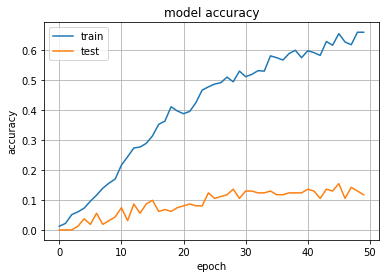

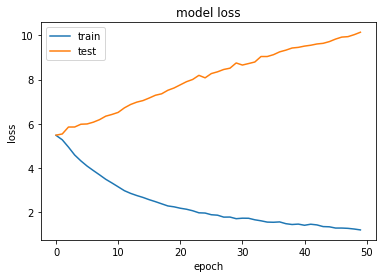

In [63]:
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')